<a href="https://colab.research.google.com/github/msc-acse/acse-9-independent-research-project-Garethlomax/blob/cuda_implementation/mastersproject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# test implementation of lstm, convlstm and cnn lstm in pytorch

# IMPORT - TORCH AND MOVING MNIST.

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# !ls

%cd /content/drive/My \Drive/masters_project/python_modules/MovingMNIST-master

# all torch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, Dataset
import torchvision.transforms as transforms
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit

import matplotlib.pyplot as plt

# importing moving mnist test set.
from MovingMNIST import MovingMNIST

%cd /content/drive/My \Drive/masters_project/python_modules/pytorch-summary-master
from torchsummary import summary

%cd /content/drive/My \Drive/masters_project/python_modules/pytorch_modelsize-master


/content/drive/My Drive/masters_project/python_modules/MovingMNIST-master
/content/drive/My Drive/masters_project/python_modules/pytorch-summary-master
/content/drive/My Drive/masters_project/python_modules/pytorch_modelsize-master


# CUDA CODE. 

In [0]:

device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
else:
    print("No GPU available!")
    
    
import random
def set_seed(seed):
    """
    Use this to set ALL the random seeds to a fixed value and take out any randomness from cuda kernels
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.benchmark = False  ##uses the inbuilt cudnn auto-tuner to find the fastest convolution algorithms. -
    torch.backends.cudnn.enabled   = False

    return True
  
set_seed(42)

Cuda installed! Running on GPU!


True

# MOVING MNIST

In [0]:
train_set = MovingMNIST(root='.data/mnist', train=True, download=True)


In [0]:
# len(train_set)
# of dimensions, sample, test data / predictordata, frame
#train_set[0][2].shape
size = train_set[8999][0].element_size() * train_set[8999][0].nelement() #print(x.element_size() * x.nelement()/ 1000000)
print(size * 9000 * 2/ 1000000)



737.28


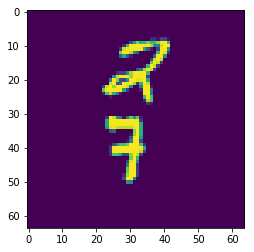

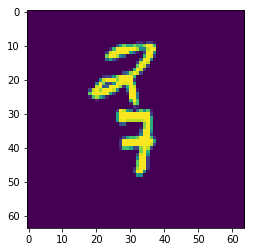

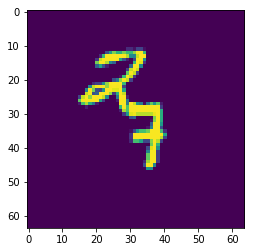

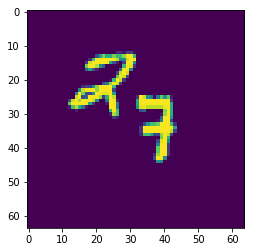

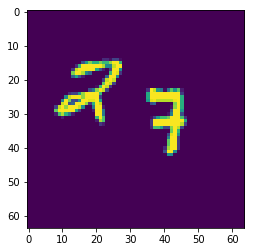

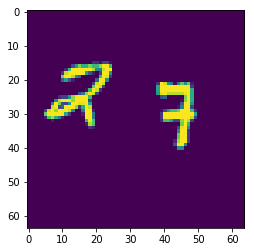

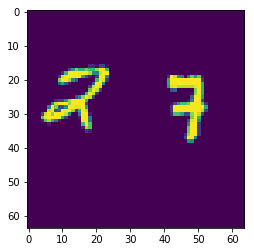

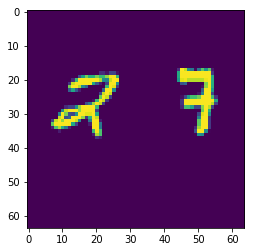

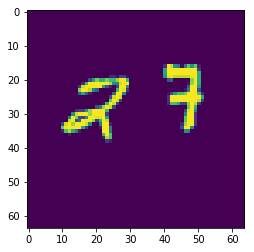

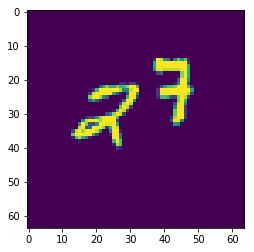

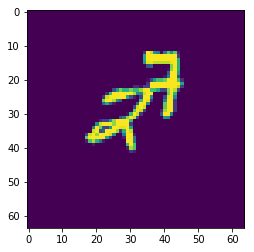

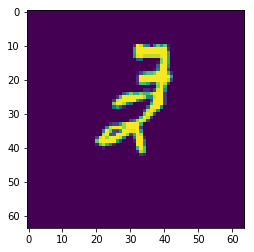

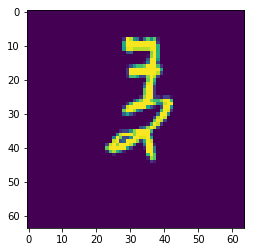

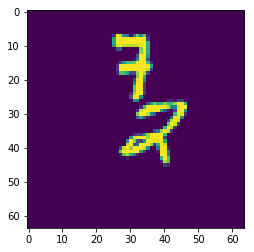

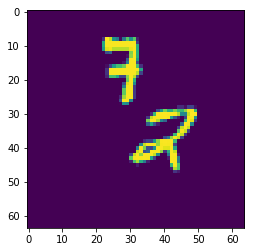

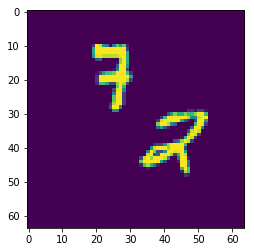

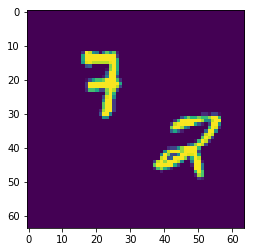

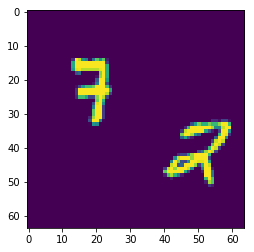

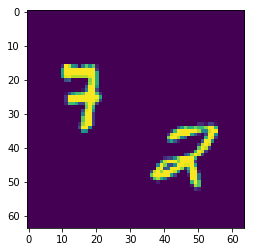

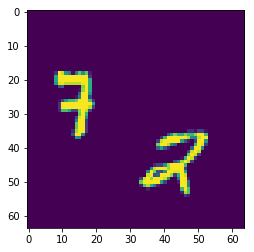

In [0]:
# examining video sequences.
for i in range(10):
    plt.figure()
    plt.imshow(train_set[0][0][i].numpy())

for i in range(10):
    plt.figure()
    plt.imshow(train_set[0][1][i].numpy())




# LSTM CELL AND MODEL

Based on lstm model from weather paper and others. 

pseudo code for lstm: 

http://people.idsia.ch/~juergen/lstm/sld024.htm





In [0]:
# now we start lstm cell

"""TODO: CUDIFY EVERYTHING"""





class LSTMunit(nn.Module):
    def __init__(self, input_channel_no, hidden_channels_no, kernel_size, stride = 1):
        super(LSTMunit, self).__init__()
        """base unit for an overall convLSTM structure. convLSTM exists in keras but
        not pytorch. LSTMunit repersents one cell in an overall convLSTM encoder decoder format
        the structure of convLSTMs lend themselves well to compartmentalising the LSTM
        cells. 
    
        Each cell takes an input the data at the current timestep Xt, and a hidden
        representation from the previous timestep Ht-1
    
        Each cell outputs Ht
        """
    
    
        self.input_channels = input_channel_no
    
        self.output_channels = hidden_channels_no
    
        self.kernel_size = kernel_size
    
        self.padding = (int((self.kernel_size - 1) / 2 ), int((self.kernel_size - 1) / 2 ))#to ensure output image same dims as input
        # as in conv nowcasting - see references 
        self.stride = stride # for same reasons as above
        
        # need convolutions, cells, tanh, sigmoid?
        # need input size for the lstm - on size of layers.
        # cannot do this because of the modules not being registered when stored in a list
        # can if we convert it to a parameter dict
    
        # list of names of filter to put in dictionary.
        # some of these are not convolutions
        """TODO: CHANGE THIS LAYOUT OF CONVOLUTIONAL LAYERS. """
        
        
        
        self.filter_name_list = ['Wxi', 'Wxf', 'Wxc', 'Wxo','Whi', 'Whf', 'Whc', 'Who']
        
        """ TODO : DEAL WITH BIAS HERE. """ 
        """ TODO: CAN INCLUDE BIAS IN ONE OF THE CONVOLUTIONS BUT NOT ALL OF THEM - OR COULD INCLUDE IN ALL? """

        # list of concolution instances for each lstm cell step
       #  nn.Conv2d(1, 48, kernel_size=3, stride=1, padding=0),
        self.conv_list = [nn.Conv2d(self.input_channels, self.output_channels, kernel_size =  self.kernel_size, stride = self.stride, padding = self.padding, bias = False) for i in range(4)]
        self.conv_list = self.conv_list + [nn.Conv2d(self.output_channels, self.output_channels, kernel_size =  self.kernel_size, stride = self.stride, padding = self.padding, bias = True) for i in range(4)]
#         self.conv_list = nn.ModuleList(self.conv_list)
        # stores nicely in dictionary for compact readability.
        # most ML code is uncommented and utterly unreadable. Here we try to avoid this
        self.conv_dict = nn.ModuleDict(zip(self.filter_name_list, self.conv_list))
    
        # may be able to combine all the filters and combine all the things to be convolved - as long as there is no cross layer convolution
        # technically the filter will be the same? - check this later.
    
        # set up W_co, W_cf, W_co as variables.
        """ TODO: decide whether this should be put into function. """
        
        
        """TODO: put correct dimensions of tensor in shape"""
        
        # of dimensions seq length, hidden layers, height, width
        """TODO: DEFINE THESE SYMBOLS. """
        
        shape = [1, self.output_channels, 32, 32]
        
        self.Wco = nn.Parameter(torch.zeros(shape).double(), requires_grad = True)
        self.Wcf = nn.Parameter(torch.zeros(shape).double(), requires_grad = True)
        self.Wci = nn.Parameter(torch.zeros(shape).double(), requires_grad = True)
#         self.Wco.name = "test"
#         self.Wco = torch.zeros(shape, requires_grad = True).double()
#         self.Wcf = torch.zeros(shape, requires_grad = True).double()
#         self.Wci = torch.zeros(shape, requires_grad = True).double()

        # activation functions.
        self.tanh = torch.tanh
        self.sig  = torch.sigmoid

#     (1, 6, kernel_size=5, padding=2, stride=1).double()
    def forward(self, x, h, c):
        """ put the various nets in here - instanciate the other convolutions."""
        """TODO: SORT BIAS OUT HERE"""
        """TODO: PUT THIS IN SELECTOR FUNCTION? SO ONLY PUT IN WXI ECT TO MAKE EASIER TO DEBUG?"""
#         print("size of x is:")
#         print(x.shape)
        # ERROR IS IN LINE 20
        #print(self.conv_dict['Wxi'](x).shape)
#         print("X:")
#         print(x.is_cuda)
#         print("H:")
#         print(h.is_cuda)
#         print("C")
#         print(c.is_cuda)
        
        i_t = self.sig(self.conv_dict['Wxi'](x) + self.conv_dict['Whi'](h) + self.Wci * c)
        f_t = self.sig(self.conv_dict['Wxf'](x) + self.conv_dict['Whf'](h) + self.Wcf * c)
        c_t = f_t * c + i_t * self.tanh(self.conv_dict['Wxc'](x) + self.conv_dict['Whc'](h))
        o_t = self.sig(self.conv_dict['Wxo'](x) + self.conv_dict['Who'](h) + self.Wco * c_t)
        h_t = o_t * self.tanh(c_t)
        
        return h_t, c_t
    
    def copy_in(self):
        """dummy function to copy in the internals of the output in the various architectures i.e encoder decoder format"""

In [0]:
9000/ 20 * 0.6


270.0

In [0]:
# test1 = (LSTMunit(20,20,5).double()).cuda()
test1 = (LSTMunit(20,20,5).float()).cuda()
# x = torch.randn((20,30,20,32,32)).double()


x = torch.randn((20, 20, 32,32)).double()
x = x.cuda()
print(x.element_size() * x.nelement()/ 1000000)
# import time
# start = time.time()


# for i in range(20):
#     x, _ = test1(x,x,x)
# "the code you want to test stays here"
# end = time.time()
# print(end - start)
# ans, _ = test1(x,x,x)
# print(ans.shape)
# shape = [1,1,8,8]
# summary(test1, [(1,224,224),(3,224,224),(3,224,224)])

# from torchvision import models
# vgg = models.vgg16().to(device)

# summary(vgg, (3, 224, 224))

# alexnet = models.AlexNet().to(device)
# summary(alexnet, (3,224,224))

3.2768


In [0]:
# from pytorch_modelsize import SizeEstimator
# se = SizeEstimator(test1, input_size=(20, 20, 32,32))
# print(se.estimate_size())



In [0]:
for param in test2.parameters():
    print(type(param.data), param.size(), param.is_cuda, param.name)

<class 'torch.Tensor'> torch.Size([1, 1, 32, 32]) True None
<class 'torch.Tensor'> torch.Size([1, 1, 32, 32]) True None
<class 'torch.Tensor'> torch.Size([1, 1, 32, 32]) True None
<class 'torch.Tensor'> torch.Size([1, 1, 5, 5]) True None
<class 'torch.Tensor'> torch.Size([1, 1, 5, 5]) True None
<class 'torch.Tensor'> torch.Size([1, 1, 5, 5]) True None
<class 'torch.Tensor'> torch.Size([1, 1, 5, 5]) True None
<class 'torch.Tensor'> torch.Size([1, 1, 5, 5]) True None
<class 'torch.Tensor'> torch.Size([1]) True None
<class 'torch.Tensor'> torch.Size([1, 1, 5, 5]) True None
<class 'torch.Tensor'> torch.Size([1]) True None
<class 'torch.Tensor'> torch.Size([1, 1, 5, 5]) True None
<class 'torch.Tensor'> torch.Size([1]) True None
<class 'torch.Tensor'> torch.Size([1, 1, 5, 5]) True None
<class 'torch.Tensor'> torch.Size([1]) True None


In [0]:
# #input_channel_no, hidden_channels_no, kernel_size, stride = 1):
# shape = [20,1,32,32]
# """TODO: IMPORTANT: STRIDE MUST BE KEPT AT 1 TO NOT DEPRECIATE THE SHAPE OF THE INPUT."""
# x = torch.randn(shape)
# h = torch.randn(shape)
# c= torch.randn(shape)

# # STRIDE ISNT WORKING - IS ONLY 1. 
# test = LSTMunit(1, 3, 5, 1)
# hout, cout = test(x,h,c)


# hout.shape

In [0]:
# hout.shape



# LSTM FULL UNIT



In [0]:
"""TODO: IMPORTANT 
WHEN COPYING STATES OVER, INITIAL STATE OF DECODER IS BOTH LAST H AND LAST C 
FROM THE LSTM BEING COPIED FROM.

WE ALSO NEED TO INCLUDE THE ABILITY TO OUTPUT THE LAST H AND C AT EACH TIMESTEP
AS INPUT.
"""


""" SEQUENCE, BATCH SIZE, LAYERS, HEIGHT, WIDTH"""

class LSTMmain(nn.Module):
    
    
    """ collection of units to form encoder/ decoder branches - decide which are which
    need funcitonality to copy in and copy out outputs.
    
    
    layer output is array of booleans selectively outputing for each layer i.e 
    for three layer can have output on second and third but not first with 
    layer_output = [0,1,1]"""
    
    """TODO: DECIDE ON OUTPUT OF HIDDEN CHANNEL LIST """
    def __init__(self, shape, input_channel_no, hidden_channel_no, kernel_size, layer_output, test_input, debug = True, save_outputs = True):
        super(LSTMmain, self).__init__()
        
        """TODO: USE THIS AS BASIS FOR ENCODER DECODER."""
        """TODO: SPECIFY SHAPE OF INPUT VECTOR"""
        
        """TODO: FIGURE OUT HOW TO IMPLEMENT ENCODER DECODER ARCHITECUTRE"""
        self.test_input = test_input
        
        self.debug = debug
        
        self.save_all_outputs = save_outputs
        
        self.shape = shape
        
        """specify dimensions of shape - as in channel length ect. figure out once put it in a dataloader"""
        
        self.layers = len(test_input) #number of layers in the encoder. 
        
        self.seq_length = shape[1]
        
        self.enc_len = len(shape)
        
        self.input_chans = input_channel_no
        
        self.hidden_chans = hidden_channel_no
        
        self.kernel_size = kernel_size
        
        self.layer_output = layer_output
        
        # initialise the different conv cells. 
#         self.unit_list = [LSTMunit(input_channel_no, hidden_channel_no, kernel_size) for i in range(self.enc_len)]
        self.dummy_list = [input_channel_no] + self.test_input
    
        self.unit_list = nn.ModuleList([(LSTMunit(self.dummy_list[i], self.dummy_list[i+1], kernel_size).double()).cuda() for i in range(len(self.test_input))])
        
        if self.debug:
            print("number of units:")
            print(len(self.unit_list))
#             print("number of ")

#         self.unit_list = nn.ModuleList(self.unit_list)
    
    
    def forward(self, x, copy_in = False, copy_out = [False, False, False]):
#     def forward(self, x):
#         copy_in = False
#         copy_out = [False, False, False]

        
#         print("IS X CUDA?")
#         print(x.is_cuda)
        """loop over layers, then over hidden states
        
        copy_in is either False or is [[h,c],[h,c]] ect.
        
        THIS IN NOW CHANGED TO COPY IN 
        
        """
        
        internal_outputs = []
        """TODO: HOW MANY OUTPUTS TO SAVE"""
        """ S """
        
        """ TODO: PUT INITIAL ZERO THROUGH THE SYSTEM TO DEFINE H AND C"""
        
        layer_output = [] # empty list to save each h and c for each step. 
        """TODO: DECIDE WHETHER THE ABOVE SHOULD BE ARRAY OR NOT"""
        
        # x is 5th dimensional tensor.
        # x is of size batch, sequence, layers, height, width
        
        """TODO: INITIALISE THESE WITH VECTORS."""
        # these need to be of dimensions (batchsizze, hidden_dim, heigh, width)
        
        size = x.shape
        
        # need to re arrange the outputs. 
        
        
        """TODO: SORT OUT H SIZING. """
        
        batch_size = size[0]
        # change this. h should be of dimensions hidden size, hidden size.
        h_shape = list(x.shape[:1] + x.shape[2:]) # seq is second, we miss it with fancy indexing
        h_shape[1] = self.hidden_chans
        if self.debug:
            print("h_shape:")
            print(h_shape)
        
        # size should be (seq, batch_size, layers, height, weight)
        
        
        empty_start_vectors = []
        
        
        for i in range(self.layers):
            """CHANGED: NOW HAS COPY IN COPY OUT BASED ON [[0,0][H,C]] FORMAT"""
            if copy_in == False: # i.e if no copying in occurs then proceed as normal
                h_shape = list(x.shape[:1] + x.shape[2:]) # seq is second, we miss it with fancy indexing
                h_shape[1] = self.dummy_list[i+1] # check indexing. 
                empty_start_vectors.append([(torch.zeros(h_shape).double()).cuda(), (torch.zeros(h_shape).double()).cuda()])
                
            elif copy_in[i] == [0,0]:
                assert (len(copy_in) == self.layers), "Length disparity between layers, copy in format"

                # if no copying in in alternate format
                h_shape = list(x.shape[:1] + x.shape[2:]) # seq is second, we miss it with fancy indexing
                h_shape[1] = self.dummy_list[i+1] # check indexing. 
                empty_start_vectors.append([torch.zeros(h_shape).double(), torch.zeros(h_shape).double()])
                
            else: # copy in the provided vectors
                assert (len(copy_in) == self.layers), "Length disparity between layers, copy in format"

                """TODO: DECIDE WHETHER TO CHANGE THIS TO AN ASSERT BASED OFF TYPE OF TENSOR."""
                empty_start_vectors.append(copy_in[i])
                
            
        
        
        
#         empty_start_vectors = [[torch.zeros(h_shape), torch.zeros(h_shape)] for i in range(self.layers)]
        
        
        
        if self.debug:
            for i in empty_start_vectors:
                print(i[0].shape)
            print(" \n \n \n")
        
#         for i in range(self.layers):
#             empty_start_vectors.append([torch.tensor()])
        
        total_outputs = []
        
        
        for i in range(self.layers):
            
            
            layer_output = []
            if self.debug:
                print("layer iteration:")
                print(i)
            # for each in layer

            """AS WE PUT IN ZEROS EACH TIME THIS MAKES OUR LSTM STATELESS"""
            # initialise with zero or noisy vectors 
            # at start of each layer put noisy vector in 
            # look at tricks paper to find more effective ideas of how to put this in
            # do we have to initialise with 0 tensors after we go to the second layer
            # or does the h carry over???
            """TODO: REVIEW THIS CHANGE"""
            
            # copy in for each layer. 
            # this is used for encoder decoder architectures.
            # default is to put in empty vectors. 
            if copy_in == False:
                h, c = empty_start_vectors[i]
            else: h, c = copy_in[i]
                
            if self.debug:
                print("new h shape")
                print(h.shape)
                
            """TODO: DO WE HAVE TO PUT BLANK VECTORS IN AT EACH TIMESTEP?"""
            
            # need to initialise zero states for c and h. 
            for j in range(self.seq_length):
                if self.debug:
                    print("inner loop iteration:")
                    print(j)
                # for each step in the sequence
                # put x through 
                # i.e put through each x value at a given time.
                
                """TODO: PUT H IN FROM PREVIOUS LAYER, BUT C SHOULD BE ZEROS AT START"""
                
                if self.debug:
                    print("inner loop size:")
                    print(x[:,j].shape)
                    print("h size:")
                    print(h.shape)
                h, c = self.unit_list[i](x[:,j], h, c)
                
                # this is record for each output in given layer.
                # this depends whether copying out it enabld 
                i
                layer_output.append([h, c])
                
            """TODO: IMPLEMENT THIS"""
#             if self.save_all_outputs[i]:
#                 total_outputs.append(layer_outputs[:,0]) # saves h from each of the layer outputs
                
            # output 
            if copy_out[i] == True:
                # if we want to copy out the contents of this layer:
                internal_outputs.append(layer_output[-1])
                # saves last state and memory which can be subsequently unrolled.
                # when used in an encoder decoder format.
            
            else:
                internal_outputs.append([0,0])
                # saves null variable so we can check whats being sent out.
            
            
            h_output = [i[0] for i in layer_output] #layer_output[:,0] # take h from each timestep.
            if self.debug:
                print("h_output is of size:")
                print(h_output[0].shape)
                
                      
            """TODO: REVIEW IF 1 IS THE CORRECT AXIS TO CONCATENATE THE VECTORS ALONG"""
            # we now use h as the predictor input to the other layers.
            """TODO: STACK TENSORS ALONG NEW AXIS. """
            
            
            x = torch.stack(h_output,0)
            x = torch.transpose(x, 0, 1)
            if self.debug:
                print("x reshaped dimensions:")
                print(x.shape)
        
#         x = torch.zeros(x.shape)
#         x.requires_grad = True
        return x , internal_outputs # return new h in tensor form. do we need to cudify this stuff

    def initialise(self):
        """put through zeros to start everything"""
        

In [0]:
bytes = torch.cuda.memory_allocated()
print("amount of memory allocated: ", bytes / 1073741824)

amount of memory allocated:  0.0036163330078125


In [0]:
shape = [2,4,1,8,8] # batch size, seq length, 1 layer, 32 by 32 image.
import numpy as np
x = (torch.randn(shape).double()).cuda()

# test2 = LSTMmain(shape, 1, 3, 5, [1], test_input = [1], debug = False).double()



test2 = (LSTMmain(shape, 1, 3, 5, [1], test_input = [1], debug = False)).to(device)
test2.cuda()
# x.cuda()
print("IS X CUDA NOW?")
print(x.is_cuda)


print("x_shape:")

print(x.shape)

# ans, _ = test2(x, copy_in = False, copy_out = [False, False, False])

# ans.shape
# ans = ans.double()
t1 = np.zeros(shape)
t1 = torch.tensor(t1, requires_grad = True).to(device)
t1 = t1.cuda()
# t1 = torch.FloatTensor([2,4,1,8,8], dtype = torch.float, requires_grad = True)
print(t1.requires_grad)
# print(ans.requires_grad)
# res = torch.autograd.gradcheck(test2, (t1,), eps=1e-4, raise_exception=True)
print(res)
# print(res)
# torch.autograd.gradcheck(test2, (ans,))
# a = list(x.shape)
# print(a[:0] + a[1:])

# a = torch.randn([20,19,32,32])
# for i in range(19):

#     print(a[:,i])
a = test2(x)
b = test2(x)



a - b

IS X CUDA NOW?
True
x_shape:
torch.Size([2, 4, 1, 8, 8])
True


NameError: ignored

In [0]:
res

In [0]:
for param in test2.parameters():
    print(type(param.data), param.size(), param.is_cuda, param.name)
    

In [0]:
print(test2)

In [0]:
for param in test2.parameters():
    print(param.device)

In [0]:
res

In [0]:
summary(test2, input_size = (1,4,1,8,8))

# ENCODER DECODER MODEL

In [0]:
class LSTMencdec(nn.Module):
    """structure is overall architecture of """
    def __init__(self, structure, input_channels, kernel_size = 5):
        assert isinstance(self.structure, np.array), "structure should be a 2d numpy array"
        assert len(structure.shape) == 2, "structure should be a 2d numpy array with two rows"
        
        """TODO: MAKE KERNEL SIZE A LIST SO CAN SPECIFY AT EACH JUNCTURE."""
        
        self.structure = structure
        self.input_channels = input_channels
        self.kernel_size = kernel_size
        
        """TODO: ASSERT THAT DATATYPE IS INT."""
        
        self.enc_shape, self.dec_shape, self.enc_copy_out, self.dec_copy_in = self.input_test()
        
        
        self.encoder = LSTMmain(shape, self.input_channels, len(self.enc_shape), self.kernel_size, layer_output = self.enc_copy_out, test_input = self.enc_shape)
        
        self.decoder = LSTMmain(shape, self.enc_shape[-1], len(self.dec_shape), self.kernel_size, layer_output = 1, test_input = self.dec_shape)
        
        
        
        # initialise encoder and decoder network
    
    def input_test(self):
        """check input structure to make sure there is overlap between encoder 
        and decoder.
        """
        # finds dimensions of the encoder
        enc_layer = self.structure[0]
        enc_layer = enc_layer[enc_layer!=0]
        dec_layer = self.structure[1]
        dec_layer = dec_layer[dec_layer!=0]
        
        
        
        
        
        
        #set up boolean grid of where the overlaps are.
        for i in range(len(enc_layer)):
            if (enc_layer != 0) and (dec_layer != 0):
                copy_grid.append(True)
            else:
                copy_grid.append(False)
                
                
        enc_overlap = copy_grid[:len(enc_layer)]
        
        num_dec_zeros = len(dec_layer[dec_layer==0]) # will this break if no zeros?
        
        dec_overlap = copy_grid[num_dec_zeros:]
        
        return enc_layer, dec_layer, enc_overlap, dec_overlap
        
#         dec_overlap = copy_grid[]                
        
                
                
#         [[1,2,3,0],
#          [0,2,3,1]]
    def forward(self, x):
        
        x, out_states = self.encoder(x, copy_in = False, copy_out = self.enc_copy_out)
        
        dummy_input = torch.zeros(x.shape)
        
        res = self.decoder(x, copy_in = out_states, copy_out = [False, False, False])
        
        return x

    

        
        
        
        
        

In [0]:
import numpy as np
a = np.array([[1,2,3,4],[4,5,6,7]])

In [0]:
# b = a[0]
b[b!=1]

# Dataset and Data Loader

## DataSet

In [0]:
# train_set.
test_set = MovingMNIST(root='.data/mnist', train=False, download=True)
# is of shape list(1000), tuple - start and finish. 




In [0]:
test_set[1][1].shape
# input is batch_size, tuple(prev, after), seq(10,), height, width
# need to go to batch, seq, chan, height, width.

print(test_set[:][0].shape) # of size 1000, 10, 64, 64

torch.Size([1000, 10, 64, 64])


In [0]:


# # test_set[0][0].shape
# class SequenceDataset(Dataset):
#     """simple data set wrapper 
#     for the moving mnist dataset
    
#     we use this as need to insert channel dimension in the data"""
#     def __init__(self, data, transform = None):
        
#         self.input_sequence = data[:][0].unsqueeze(2)
        
#         self.output_sequence = data[:][1].unsqueeze(2)# this should be the moving mnist sent in
        
#         assert len(self.input_sequence.shape) == 5, "internal data should be : batch_size, sequence_length, channels, height, width"
        
        
# #         print(self.input_sequence.shape)
        
        
#     def __len__(self):
#         return len(self.input_sequence)
    
#     def __getitem__(self, i):
#         """returns tuple of predictor and result sequence
        
#         This should later be specified to return a valid number of steps in the future
        
#         i.e can specify whether want input of 10 and to predict 5 ect."""
                

        
#         return self.input_sequence[i], self.output_sequence[i]
    
        

In [0]:
class SequenceDataset(Dataset):
    """simple data set wrapper 
    for the moving mnist dataset
    
    we use this as need to insert channel dimension in the data"""
    def __init__(self, predictor, ground_truth, transform = None):
        
        self.input_sequence = predictor
        
        self.output_sequence = ground_truth
        
        assert len(self.input_sequence.shape) == 5, "internal data should be : batch_size, sequence_length, channels, height, width"
        
        
#         print(self.input_sequence.shape)
        
       
    def __len__(self):
        return len(self.input_sequence)
    
    def __getitem__(self, i):
        """returns tuple of predictor and result sequence
        
        This should later be specified to return a valid number of steps in the future
        
        i.e can specify whether want input of 10 and to predict 5 ect."""
                

        
        return self.input_sequence[i], self.output_sequence[i]
    

In [0]:
# test = SequenceDataset(test_set)

In [0]:
test[0:4][0].shape

torch.Size([4, 10, 1, 64, 64])

In [0]:
a = test_set[:][0]
print(a.shape)
b = a.unsqueeze(1)
b.shape
print(len(b.shape))

torch.Size([1000, 10, 64, 64])
5


In [0]:
test[0].shape

AttributeError: ignored

## Data Loader
num_workers parameter is useful for bypassing large data set issues. this is very relevant for future work.



#TRAINING FUNCTIONS - ENC DEC


## Load in datasets

In [0]:
train_set = MovingMNIST(root='.data/mnist', train=True, download=True)
test_set = MovingMNIST(root='.data/mnist', train=False, download=True)

In [0]:
data = 10
dummy_array = np.zeros(data)
split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.1, random_state = 32)
generator = split.split(torch.tensor(dummy_array), torch.tensor(dummy_array))
indices = [(a, b) for a, b in generator][0]
print(indices)

# for a, b in generator:
#     print(a, b)

(array([9, 4, 6, 5, 3, 1, 2, 0, 8]), array([7]))


## Function to shuffle the dataset 

layter include kfold validaiton. 

In [0]:
def validation_split(data, n_splits = 1, valid_fraction = 0.1, random_state = 0):
    """
    Function to produce a validation set from test set.
    THIS SHUFFLES THE SAMPLES. __NOT__ THE SEQUENCES.
    """
    dummy_array = np.zeros(len(data))
    split = StratifiedShuffleSplit(n_splits, test_size = valid_fraction, random_state = 0)
    generator = split.split(torch.tensor(dummy_array), torch.tensor(dummy_array))
    return [(a,b) for a, b in generator][0]


## Unsqueeze data

In [0]:
def unsqueeze_data(data):
    """
    Takes in moving MNIST object - must then account for 
    """
    
    # split moving mnist data into predictor and ground truth.
    predictor = data[:][0].unsqueeze(2)
        
    truth = data[:][1].unsqueeze(2)# this should be the moving mnist sent in
    
    return predictor, truth
    # the data should now be unsqueezed.


## Produce Datasets

In [0]:
def initialise_dataset(data):
    # unsqueeze data, adding a channel dimension for later convolution. 
    # this also gets rid of the annoying tuple format
    predictor, truth = unsqueeze_data(data)
    
    train_index, valid_index = validation_split(data)
    
    train_predictor = predictor[train_index]
    valid_predictor = predictor[valid_index]
    
    train_truth = truth[train_index]
    valid_truth = truth[valid_index]
    
    train_dataset = SequenceDataset(train_predictor, train_truth)
    valid_dataset = SequenceDataset(valid_predictor, valid_truth)
    
    return train_dataset, valid_dataset

### Test of produce dataset function

In [0]:
## test 

train, valid = initialise_dataset(train_set)






In [0]:
train[0][0].shape

torch.Size([10, 1, 64, 64])

As we can see below, works as intended. note that shape now has a channel , which must be specified.

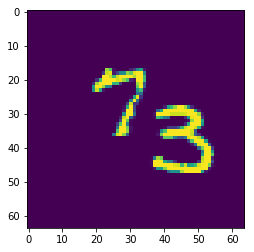

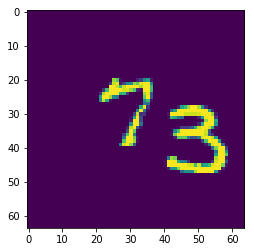

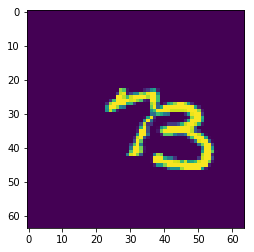

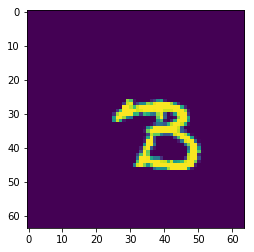

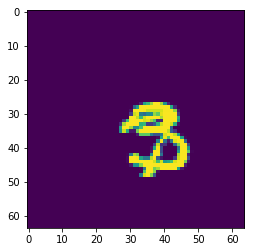

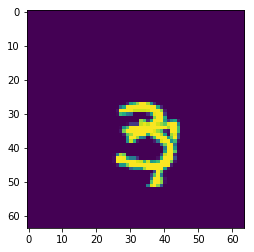

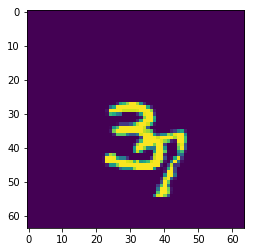

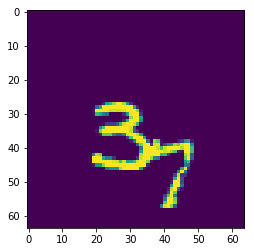

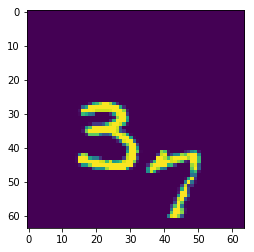

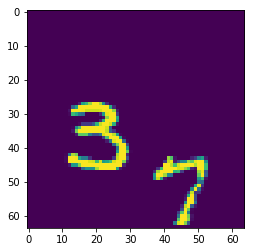

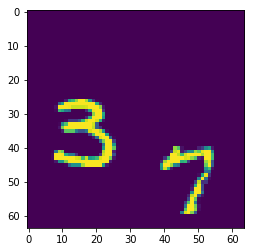

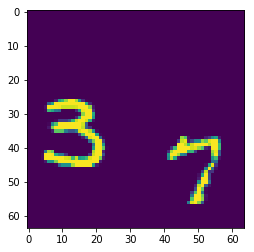

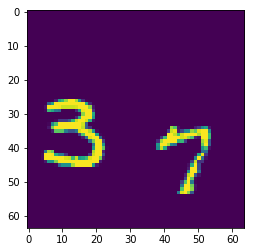

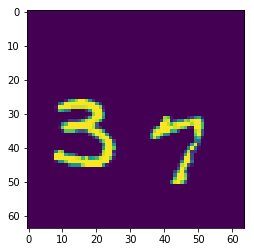

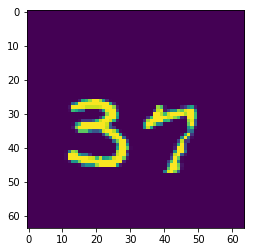

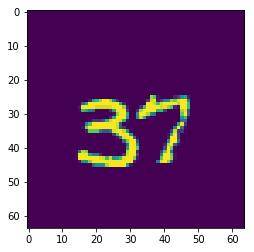

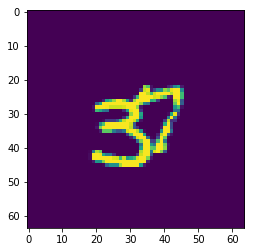

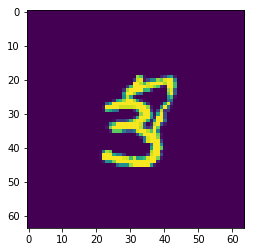

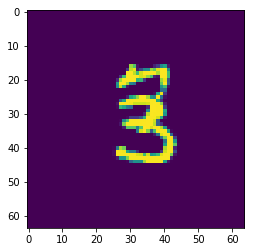

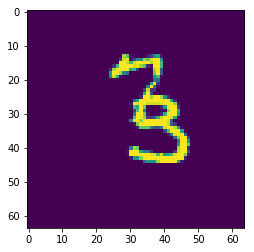

In [0]:
for i in range(10):
    plt.figure()
    plt.imshow(train[0][0][i][0].numpy())

for i in range(10):
    plt.figure()
    plt.imshow(train[0][1][i][0].numpy())

## patch size alteration

## Define Training Functions 

In [0]:

def train_enc_dec(model, optimizer, dataloader, loss_func = nn.MSEloss()):
    """
    training function 
    
    by default mseloss
    
    could try brier score.
    
    """
    model.train() # enables training for model. 
    for x, y in dataloader:
        x.to(device) # send to cuda.
        y.to(device)
        optimizer.zero_grad() # zeros saved gradients in the optimizer.
        # prevents multiple stacking of gradients
        # this is important to do before we evaluate the model as the 
        # model is currenly in model.train() mode
        
        prediction = model(x) #x should be properly formatted - of size
        """THIS DOESNT DEAL WITH SEQUENCE LENGTH VARIANCE OF PREDICTION OR Y"""
        loss = loss_func(prediction, y)
        
        loss.backward() # differentiates to find minimum.
        
        ##
        # implement the interpreteable stuff here.
        # as it is very unlikely we predict every pixel correctly we will not 
        # use accuracy. 
        # technically this is a regression problem, not a classification.
        
        
        optimizer.step() # steps forward the optimizer.
        # uses loss.backward() to give gradient. 
        # loss is negative.
    return trainloss, trainaccuracy 

def validate(model, dataloader, criterion = nn.MSEloss()):
    """as for train_enc_dec but without training - and acting upon validation
    data set
    """
    model.eval() # puts out of train mode so we do not mess up our gradients
    for x, y in dataloader:
        with torch.no_grad: # no longer have to specify tensors 
            # as volatile = True. as of modern pytorch use torch.no_grad.
            
            x.to(device) # send to cuda.
            y.to(device)
            prediction = model(x)
            
            loss = loss_func(prediction, y)
            
            
    return validloss, validaccuracy





def train_main(model, params, train, valid, epochs = 30):
    # make sure model is ported to cuda
    # make sure seed has been specified if testing comparative approaches
    if model.is_cuda == False:
        model.to(device)
    
    # initialise optimizer on model parameters 
    optimizer = torch.optim.Adam(model.parameters())
    loss_func = nn.MSEloss()
    
    train_loader = Dataloader(train, batch_size = batch_size, shuffle = True) # implement moving MNIST data input
    validation_loader = Dataloader(valid, batch_size = batch_size, shuffle = False) # implement moving MNIST
    
    for _ in range(epochs):
        
        train_enc_dec(model, optimizer, train_loader)
        
        validate(model, validation_loader)
        
        
        
    
    
    
            
            
            
            
    


        
        
        
        
        
        
        
        
        
        
        
        

AttributeError: ignored

# Training function

In [0]:
train, valid = initialise_dataset(train_set)
